In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use('CMS')

$$ \LARGE p_i = \frac{1}{Q} e^{-\varepsilon_i /k_B T} = \frac{e^{-\varepsilon_i /k_B T}}{\sum^M_{j=1} e^{-\varepsilon_j /k_B T} }$$

According to Scipy this is the same as 
$$ \LARGE f(k) = \frac{ 1-e^{-\lambda}}{ 1-e^{-\lambda N}}e^{-\lambda k} $$
With $\lambda = 1/k_B T$, $k = \varepsilon_i$


## Write a routine that generates N initial conditions ($x_0 , p_0$) with a Boltzmann probability distribution for our ideal gas particle in the piston and calculates $W_c(x_0, p_0) + W_e(x_0, p_0)$ for each.

In [276]:
def generate_space(Npoints: int ,m: int=2,V: int = 2,L: int=20,kT: int=8) -> tuple: 
    ''' Generates Npoints of initial conditions with a boltzmann distribution for x0 and p0
    '''
    x0=stats.boltzmann.rvs(lambda_=1/kT,N=L,loc=0,size=Npoints)
    p0=stats.boltzmann.rvs(lambda_=1/kT,N=2*m*V,loc=-m*V,size=Npoints)
    return x0,p0


def work(x0,p0,m=2,V=2):  
    '''Calculates the compression work and expansion work done on the particle (We,Wc) respectively
    '''
    Wc = .5*m*V**2 + V*p0
    We = 2*V*p0
    return Wc,We


def calculate_work(Npoints,L=20,Lprime=19,V=2,m=2):
    x0,p0 = generate_space(Npoints,m,V,L,kT=8)
    Wctemp,Wetemp = work(x0,p0,m,V)
    deltaL=L-Lprime
    x1 = (deltaL)*(1-p0/(m*V)) 
    x2= (deltaL)*(-2*p0/(m*V))
    xcut = ((x0>x1) | (x0>x2)) 
    pcut =  p0<=-m*V
    Wctemp[(x0>=x1) ] = 0
    Wetemp[xcut & p0>=-m*V ] = 0 # Wetemp has to have many more zeroes because the space does not privide many configurations for particle to collide with the piston
    Wc= Wctemp[:]
    We= Wetemp[:]
    return Wc,We

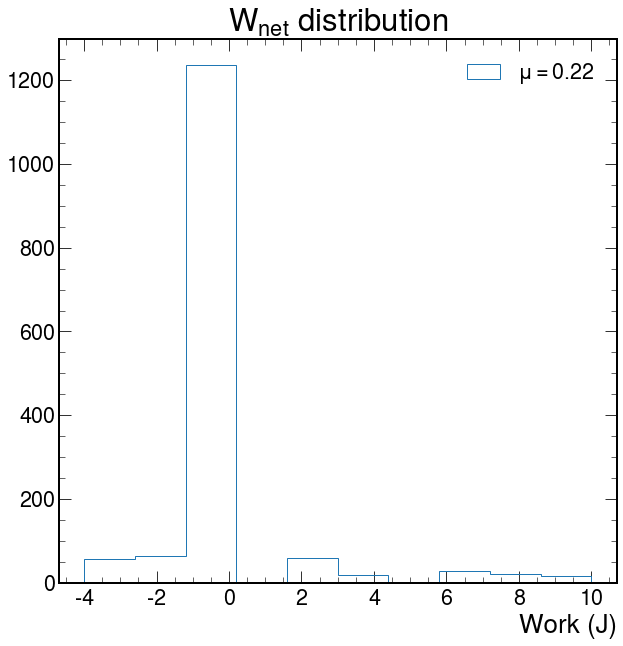

In [275]:
Wc,We = calculate_work(1500)
Wnet = Wc + We
mean = Wnet.mean()
plt.hist(Wnet,density=False,cumulative=False,histtype='step',label=f'$\mu = ${mean:.4}');
plt.legend(loc='best')
plt.title('$W_{net}$ distribution')
plt.xlabel('Work (J)')
# plt.tight_layout()
plt.show()

In [ ]:
# def boltzmann_mine(E,kT=8,M=1000):
#     Q= sum([np.exp(-ej/kT) for ej in range(M)])
#     p = np.exp(-E/kT)/Q
#     return p
# # boltzmann_mine(E=np.arange(10),M=N)

# Calculate the average work done by the piston $W_c +W_e$. How big must N be before you get a reliable average? 

In [196]:
calculate_work()

(array([ 0, 17,  6,  0, 15,  0, 17, 11,  8,  1,  0, 17,  9, 18,  5,  5,  2,
         4,  1, 17]),
 array([-4,  3,  1, -2, -4, -2, -1,  1,  0,  2,  3, -3, -4,  2, -2, -4, -2,
         2, -2,  0]))



N must be at least around 500 to be reliable based on a quick study of the outputs of my boltzmann function.


## Does your average obey eqn 4.18?
Yes it does.


In [ ]:
np.mean(Wc+We)

## Use your routine with $N = 1,000$ to calculate Jarzynski’s exponentially weighted average $\overline{{\exp (−W/k_B T)}}$ in eqn 4.19, and compare to $\exp (-\overline{W}/ k_B T )$. Do this 200 times, and plot a histogram of each. Does the Jarzynski equality appear to hold?

Since I already initialized it with N=1000 above I will just evaluate these terms

In [ ]:
W= Wc+We
kT=8
print(f"Jarzynki's weighted average {np.mean(np.exp(-W/kT)):.4f}")
print(f"exp(bar(-W)/kT) = {np.exp(-np.mean(W)/kT):.4f}")


We could not recreate the simulation succesfully it seems